# Real Estate Data Analysis Project
This project involves exploring, cleaning, and analyzing a real estate dataset to identify key insights and develop predictive models for property sale prices.

## Import Libraries:

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy import stats
from scipy.stats import zscore, boxcox, yeojohnson
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from google.colab import files
uploaded = files.upload()


Saving real-estate-sales-730-days-1 (1).csv to real-estate-sales-730-days-1 (1) (2).csv


## Load Data:

In [172]:
# Load dataset
data = pd.read_csv('real-estate-sales-730-days-1.csv')
data.head()


,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,ParcelID,LocationStartNumber,ApartmentUnitNumber,StreetNameAndWay,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,LivingUnits,OwnerLastName,OwnerFirstName,PrimaryGrantor,SaleDate,SalePrice,TotalAppraisedValue,LegalReference,xrSalesValidityID,xrDeedID
0,30,3,4.0,144-698-048,22.0,NaN,BRISTOL ST,2,6000.0,1422.0,1.0,KHAN,BIBI,ALI MUNTAAZ,12/10/2019,0,136600,07559-0116,5,8
1,50,3,4.0,121-698-073,164.0,NaN,HOLLYWOOD AVE,2,5650.0,1384.0,1.0,GONZALEZ,LOURDES,GONZALEZ JOHNETTE,12/18/2019,179900,158400,07561-0225,1,10
2,58,3,6.0,121-699-090,87.0,NaN,BRISTOL ST,2,5850.0,1249.0,1.0,SAMPAYO,YARLIS,FLOYD ANNIE J ESTATE,05/24/2019,174900,144400,07485-0035,12,1
3,66,3,6.0,144-699-037,55.0,NaN,BRISTOL ST,2,5900.0,1390.0,1.0,CARRILLO PACHECO,RICARDO,HARGROVE DAVID L,09/10/2019,140000,142400,07523-0330,1,10
4,78,3,3.0,144-699-025,5.0,NaN,BRISTOL ST,2,7788.0,960.0,1.0,VARJABEDIAN ROSE M (L.U.),NaN,VARJABEDIAN ANTHONY ( L U),05/14/2020,0,147900,07616-0064,11,7


## Data Cleaning:

In [173]:
# 1. Handling Missing Data
print("Missing Data Summary:\n", data.isnull().sum())

# Impute missing numerical values with mean
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# Fill missing values in the "ApartmentUnitNumber" column with 0
data['ApartmentUnitNumber'] = data['ApartmentUnitNumber'].fillna(0)


# 2. Dealing with Duplicates
data.drop_duplicates(subset=['ParcelID', 'SaleDate'], keep='first', inplace=True)


# 3. Handling Outliers
Q1 = data['SalePrice'].quantile(0.25)
Q3 = data['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
outliers = data[(data['SalePrice'] < Q1 - 1.5 * IQR) | (data['SalePrice'] > Q3 + 1.5 * IQR)]

# Cap SalePrice between the 1st and 99th percentile
data['SalePrice'] = np.clip(data['SalePrice'], data['SalePrice'].quantile(0.01), data['SalePrice'].quantile(0.99))



data['SaleDate'] = pd.to_datetime(data['SaleDate'], errors='coerce')

# 4. Standardizing and Normalizing Data
data['TotalFinishedArea_zscore'] = zscore(data['TotalFinishedArea'])

scaler = MinMaxScaler()
data['LandSF_norm'] = scaler.fit_transform(data[['LandSF']])

# 5. Handling Inconsistent Data
data['StreetNameAndWay'] = data['StreetNameAndWay'].str.replace('ST', 'Street', regex=False)

data['SaleDate'] = pd.to_datetime(data['SaleDate'], errors='coerce')
data = data[data['SaleDate'].notnull()]

# 6. Removing Irrelevant Data
columns_to_drop = ['LegalReference', 'OwnerLastName', 'OwnerFirstName']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# Display summary statistics
print("\n\nCleaned Data Summary:\n")
data.describe()


Missing Data Summary:
 PropertyID                    0
xrCompositeLandUseID          0
xrBuildingTypeID             16
ParcelID                      0
LocationStartNumber           1
ApartmentUnitNumber        3261
StreetNameAndWay              0
xrPrimaryNeighborhoodID       0
LandSF                      570
TotalFinishedArea           199
LivingUnits                  16
OwnerLastName                 1
OwnerFirstName             2360
PrimaryGrantor                0
SaleDate                      0
SalePrice                     0
TotalAppraisedValue           0
LegalReference                7
xrSalesValidityID             0
xrDeedID                      0
dtype: int64


Cleaned Data Summary:



,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,LocationStartNumber,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,LivingUnits,SaleDate,SalePrice,TotalAppraisedValue,xrSalesValidityID,xrDeedID,TotalFinishedArea_zscore,LandSF_norm
count,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4.370000e+03,4370.000000,4370.000000,4370,4.370000e+03,4.370000e+03,4370.000000,4370.000000,4.370000e+03,4370.000000
mean,14875.028604,128.918764,14.131863,205.302144,188.829062,8.309114e+03,4103.812941,2.288618,2019-08-01 22:25:25.675057152,7.145883e+05,2.007141e+05,12.782380,10.611670,1.951147e-17,0.005269
min,11.000000,3.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,2018-08-27 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.824173e-01,0.000000
25%,7147.250000,4.000000,6.000000,38.000000,47.000000,0.000000e+00,894.000000,1.000000,2019-01-31 00:00:00,0.000000e+00,5.050000e+04,1.000000,8.000000,-1.426784e-01,0.000000
50%,14632.500000,5.000000,12.000000,96.000000,151.000000,6.500000e+03,1813.000005,1.000000,2019-08-08 12:00:00,1.150000e+05,1.296500e+05,11.000000,10.000000,-1.018282e-01,0.004122
75%,21669.250000,167.000000,16.000000,213.000000,284.000000,9.110300e+03,3639.750000,2.000000,2019-12-17 00:00:00,3.500000e+05,1.724000e+05,25.000000,10.000000,-2.062792e-02,0.005777
max,28862.000000,458.000000,105.000000,3466.000000,496.000000,1.576872e+06,983691.590000,266.000000,2020-08-21 00:00:00,8.500000e+06,6.408700e+07,27.000000,22.000000,4.354335e+01,1.000000
std,8829.246935,189.146750,12.136592,346.652159,155.683542,3.910648e+04,22499.414133,7.931783,NaN,1.483402e+06,1.165975e+06,10.406853,4.223175,1.000114e+00,0.024800


## Exploratory Data Analysis (EDA)
### Normal Distribution & Skewness

### Scatter Plots:

Text(0, 0.5, 'Sale Price')

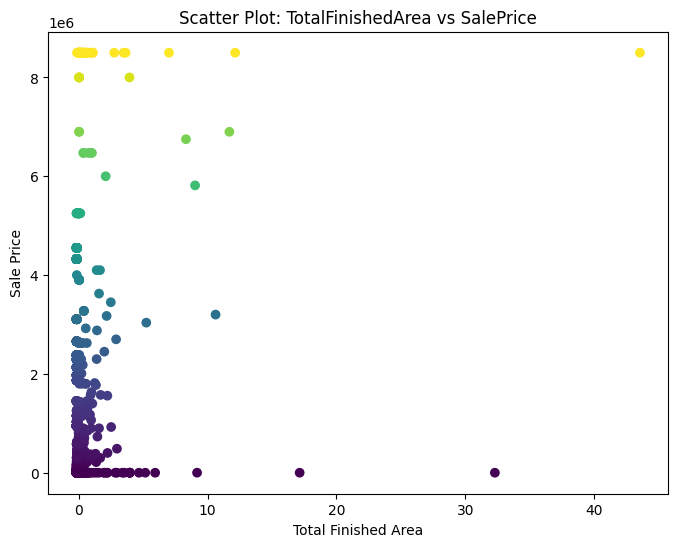

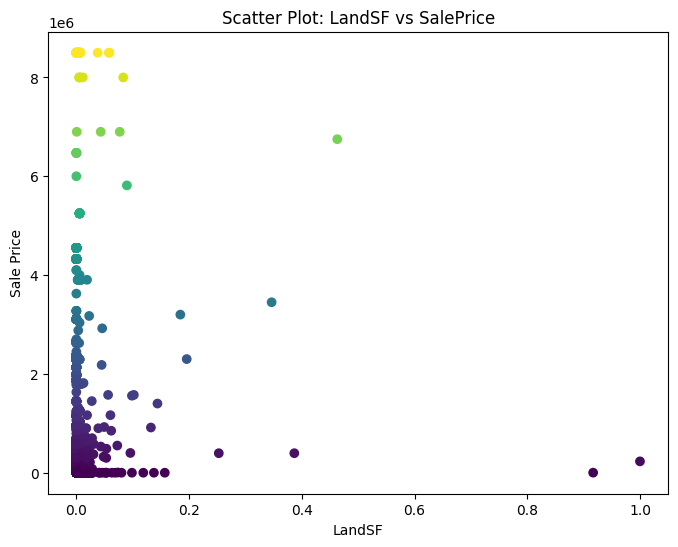

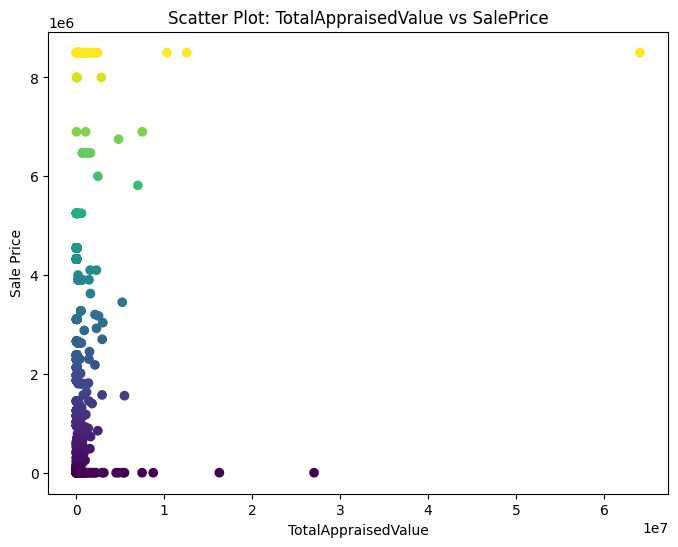

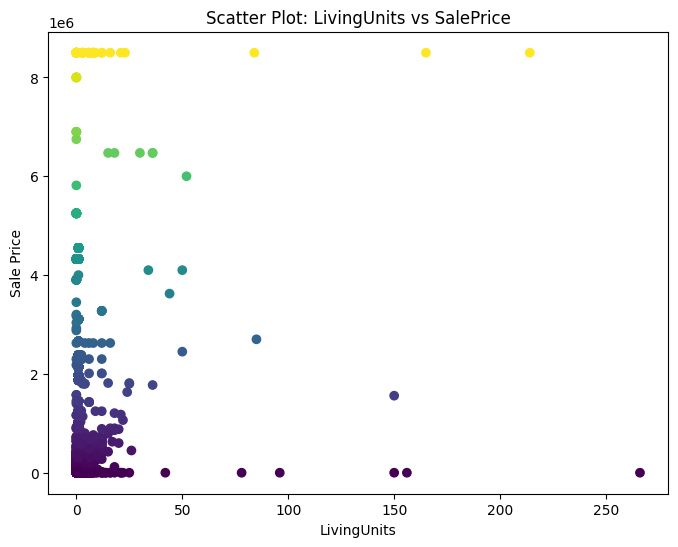

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# Use plt.scatter to plot with a color gradient based on SalePrice
scatter = plt.scatter(x=data['TotalFinishedArea_zscore'], y=data['SalePrice'],c=data['SalePrice'])
plt.title('Scatter Plot: TotalFinishedArea vs SalePrice')
plt.xlabel('Total Finished Area')
plt.ylabel('Sale Price')


plt.figure(figsize=(8, 6))
# Use plt.scatter to plot with a color gradient based on SalePrice
scatter = plt.scatter(x=data['LandSF_norm'], y=data['SalePrice'],c=data['SalePrice'])
plt.title('Scatter Plot: LandSF vs SalePrice')
plt.xlabel('LandSF')
plt.ylabel('Sale Price')
plt.figure(figsize=(8, 6))


# Use plt.scatter to plot with a color gradient based on SalePrice
scatter = plt.scatter(x=data['TotalAppraisedValue'], y=data['SalePrice'],c=data['SalePrice'])
plt.title('Scatter Plot: TotalAppraisedValue vs SalePrice')
plt.xlabel('TotalAppraisedValue')
plt.ylabel('Sale Price')


plt.figure(figsize=(8, 6))
# Use plt.scatter to plot with a color gradient based on SalePrice
scatter = plt.scatter(x=data['LivingUnits'], y=data['SalePrice'],c=data['SalePrice'])
plt.title('Scatter Plot: LivingUnits vs SalePrice')
plt.xlabel('LivingUnits')
plt.ylabel('Sale Price')




### Box Plot:

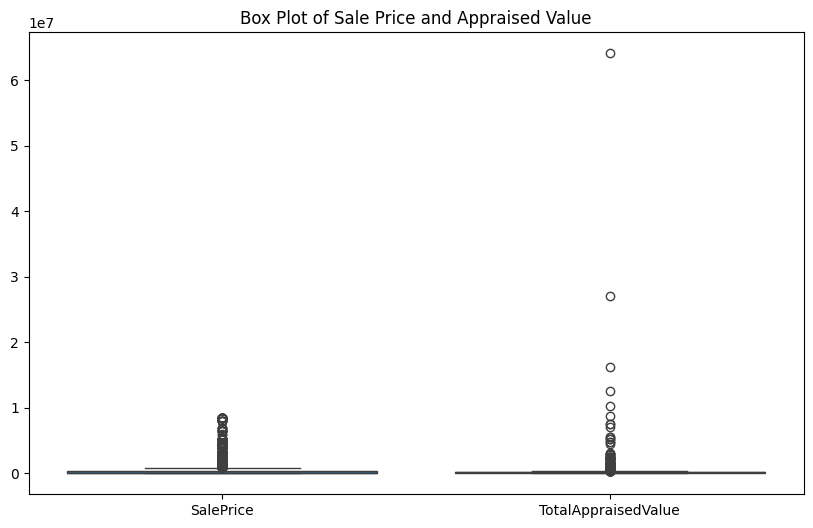

In [175]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['SalePrice','TotalAppraisedValue']])
plt.title('Box Plot of Sale Price and Appraised Value')
plt.show()


### Correlation Matrix:

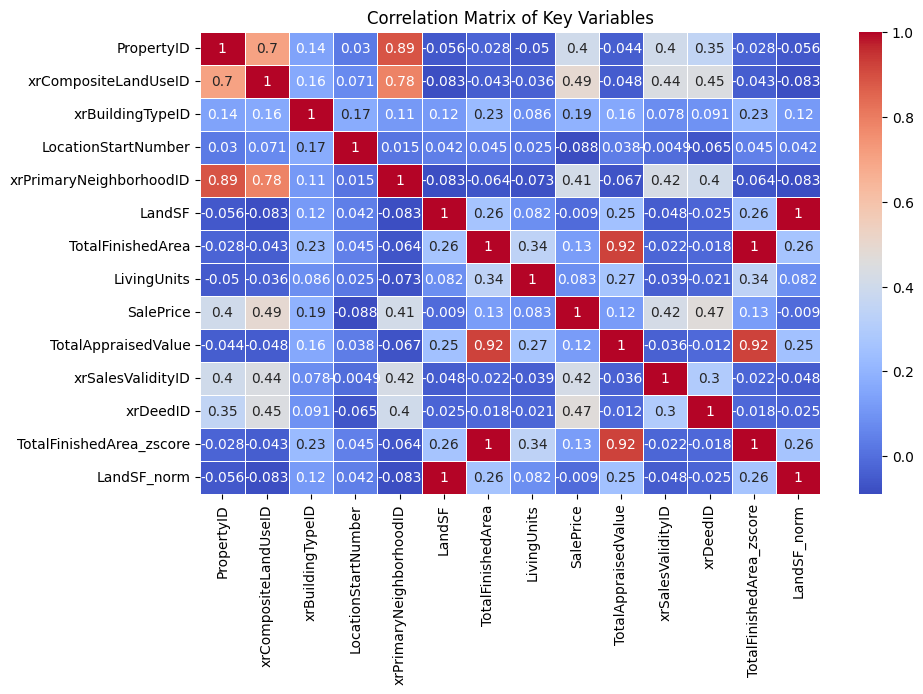

In [176]:
# Correlation Matrix (for numeric data only)
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Variables')
plt.show()

### Normality Assessment (Using QQ Plot and Skewness):

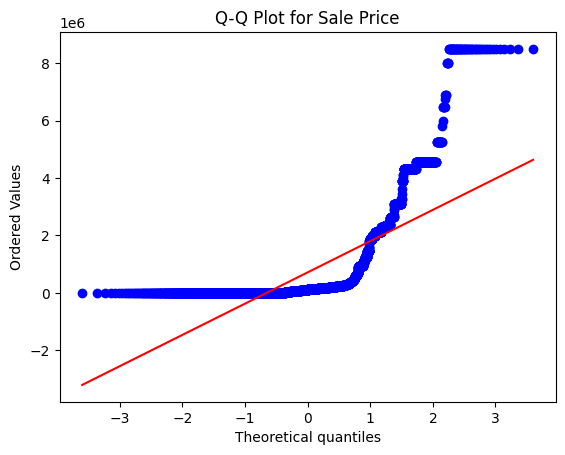

Skewness: 2.974805276712786
Kurtosis: 9.87293674623835


In [177]:
stats.probplot(data['SalePrice'], dist='norm', plot=plt)
plt.title('Q-Q Plot for Sale Price')
plt.show()
print('Skewness:', data['SalePrice'].skew())
print('Kurtosis:', data['SalePrice'].kurt())

## Data Transformation

In [178]:


# Original Skewness Check
print(f"Original Skewness of SalePrice: {data['SalePrice'].skew()}")

# Apply Transformations
data['SalePrice_log'] = np.log1p(data['SalePrice'])  # Log transformation
data['SalePrice_sqrt'] = np.sqrt(data['SalePrice'])  # Square root transformation
data['SalePrice_boxcox'], boxcox_lambda = boxcox(data['SalePrice'] + 1)  # Box-Cox transformation
data['SalePrice_yeojohnson'], yeojohnson_lambda = yeojohnson(data['SalePrice'] + 1)  # Yeo-Johnson transformation

# Skewness After Transformations
print(f"Skewness after Log Transformation: {data['SalePrice_log'].skew()}")
print(f"Skewness after Square Root Transformation: {data['SalePrice_sqrt'].skew()}")
print(f"Skewness after Box-Cox Transformation: {pd.Series(data['SalePrice_boxcox']).skew()}")
print(f"Skewness after Yeo-Johnson Transformation: {pd.Series(data['SalePrice_yeojohnson']).skew()}")


Original Skewness of SalePrice: 2.974805276712786
Skewness after Log Transformation: -0.5183083379962364
Skewness after Square Root Transformation: 1.5881948489561226
Skewness after Box-Cox Transformation: -0.2928127578837244
Skewness after Yeo-Johnson Transformation: -0.2747527362800273


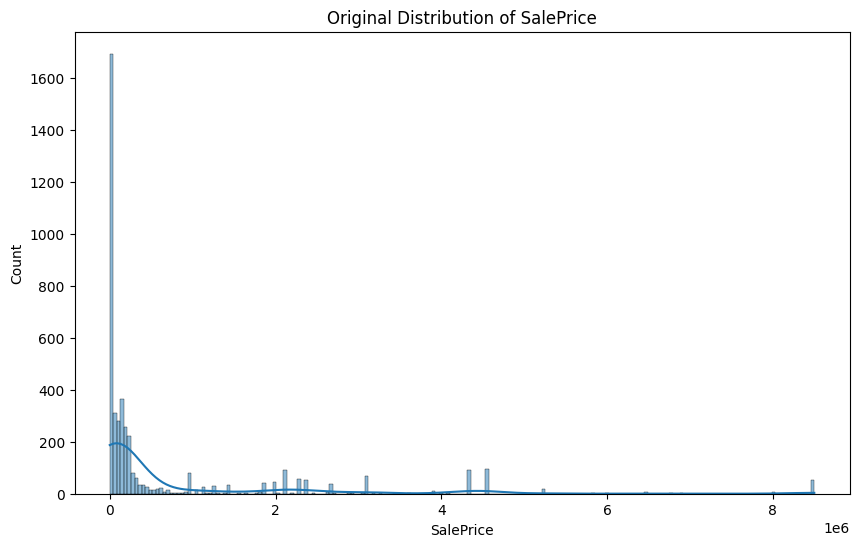

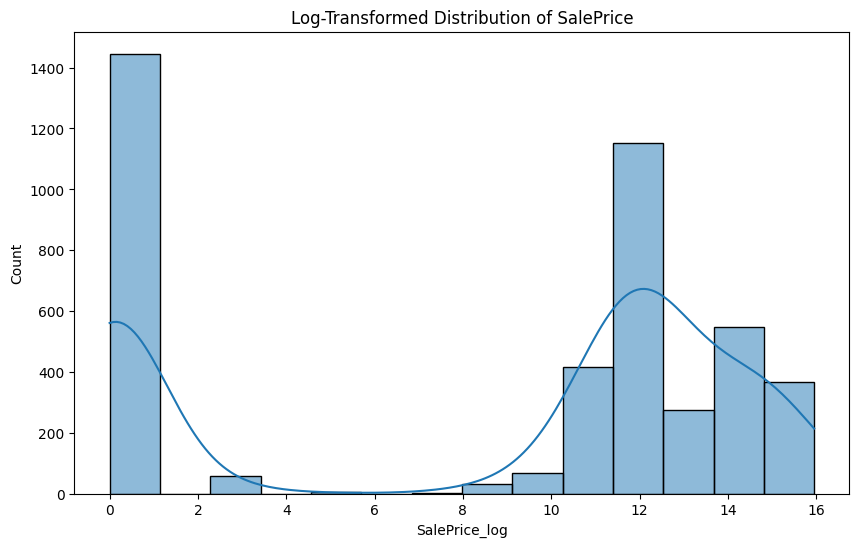

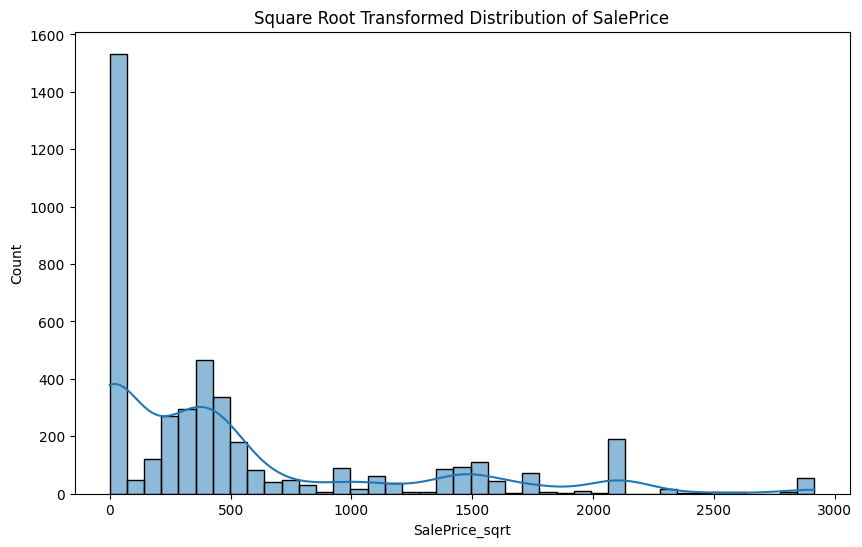

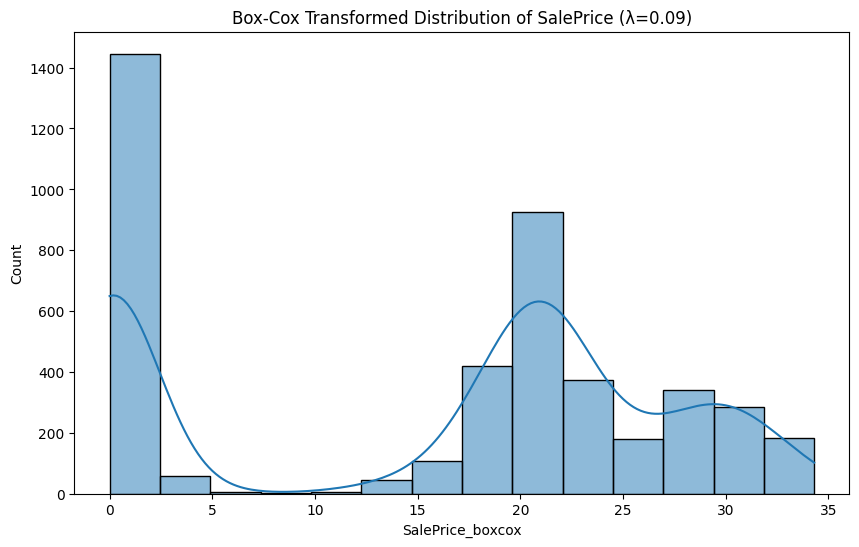

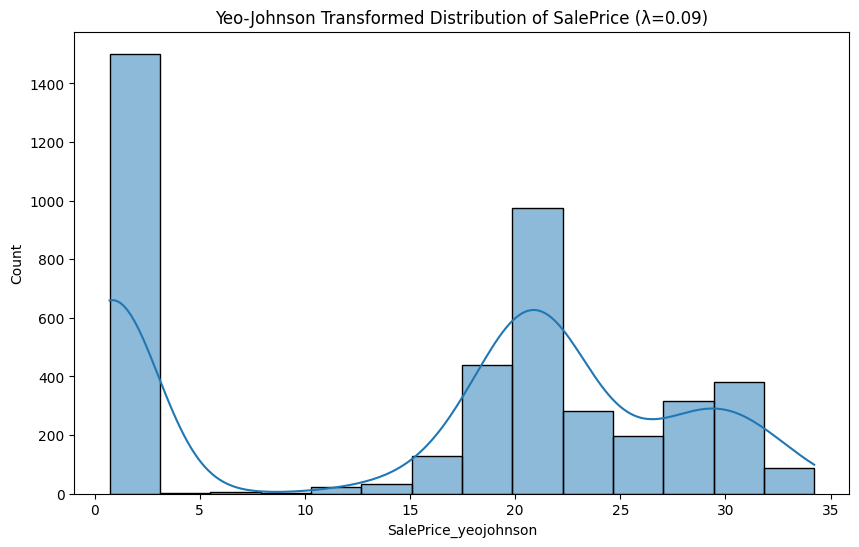

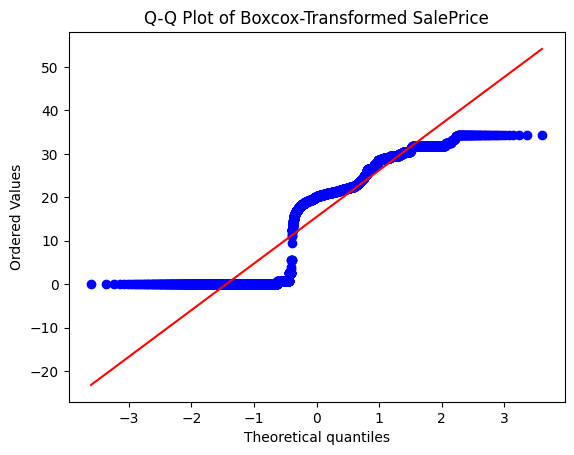

Skewness: -0.2928127578837244
Kurtosis: -1.4555418309479646


In [179]:


# Plot original distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True)
plt.title('Original Distribution of SalePrice')
plt.show()

# Log Transformation Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice_log'], kde=True)
plt.title('Log-Transformed Distribution of SalePrice')
plt.show()

# Square Root Transformation Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice_sqrt'], kde=True)
plt.title('Square Root Transformed Distribution of SalePrice')
plt.show()

# Box-Cox Transformation Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice_boxcox'], kde=True)
plt.title(f'Box-Cox Transformed Distribution of SalePrice (λ={boxcox_lambda:.2f})')
plt.show()

# Yeo-Johnson Transformation Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice_yeojohnson'], kde=True)
plt.title(f'Yeo-Johnson Transformed Distribution of SalePrice (λ={yeojohnson_lambda:.2f})')
plt.show()

# Q-Q Plot for Boxcox Transformation
stats.probplot(data['SalePrice_boxcox'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Boxcox-Transformed SalePrice')
plt.show()
print('Skewness:', data['SalePrice_boxcox'].skew())
print('Kurtosis:', data['SalePrice_boxcox'].kurt()) #−0.5≤Skewness≤0.5



## Data Preprocessing:

### Encoding Categorical Variables:

In [180]:
label_encoder = LabelEncoder()
data['StreetNameAndWay'] = label_encoder.fit_transform(data['StreetNameAndWay'])
data.head()

,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,ParcelID,LocationStartNumber,ApartmentUnitNumber,StreetNameAndWay,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,...,SalePrice,TotalAppraisedValue,xrSalesValidityID,xrDeedID,TotalFinishedArea_zscore,LandSF_norm,SalePrice_log,SalePrice_sqrt,SalePrice_boxcox,SalePrice_yeojohnson
0,30,3,4.0,144-698-048,22.0,0,56,2,6000.0,1422.0,...,0,136600,5,8,-0.119208,0.003805,0.000000,0.000000,0.000000,0.714212
1,50,3,4.0,121-698-073,164.0,0,203,2,5650.0,1384.0,...,179900,158400,1,10,-0.120898,0.003583,12.100162,424.146201,21.322148,21.283378
2,58,3,6.0,121-699-090,87.0,0,56,2,5850.0,1249.0,...,174900,144400,12,1,-0.126898,0.003710,12.071975,418.210473,21.242245,21.203723
3,66,3,6.0,144-699-037,55.0,0,56,2,5900.0,1390.0,...,140000,142400,1,10,-0.120631,0.003742,11.849405,374.165739,20.618081,20.581479
4,78,3,3.0,144-699-025,5.0,0,56,2,7788.0,960.0,...,0,147900,11,7,-0.139745,0.004939,0.000000,0.000000,0.000000,0.714212


### Feature Scaling:

In [189]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['TotalFinishedArea', 'LandSF', 'TotalAppraisedValue','LivingUnits','LocationStartNumber','StreetNameAndWay']])
data[['TotalFinishedArea', 'LandSF', 'TotalAppraisedValue','LivingUnits','LocationStartNumber','StreetNameAndWay']] = scaled_features
data.head()

,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,ParcelID,LocationStartNumber,ApartmentUnitNumber,StreetNameAndWay,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,...,SalePrice,TotalAppraisedValue,xrSalesValidityID,xrDeedID,TotalFinishedArea_zscore,LandSF_norm,SalePrice_log,SalePrice_sqrt,SalePrice_boxcox,SalePrice_yeojohnson
0,30,3,4.0,144-698-048,-0.528839,0,-1.224766,2,-0.059054,-0.119208,...,0,-0.054994,5,8,-0.119208,0.003805,0.000000,0.000000,0.000000,0.714212
1,50,3,4.0,121-698-073,-0.119159,0,-0.074678,2,-0.068005,-0.120898,...,179900,-0.036295,1,10,-0.120898,0.003583,12.100162,424.146201,21.322148,21.283378
2,58,3,6.0,121-699-090,-0.341310,0,-1.224766,2,-0.062890,-0.126898,...,174900,-0.048303,12,1,-0.126898,0.003710,12.071975,418.210473,21.242245,21.203723
3,66,3,6.0,144-699-037,-0.433632,0,-1.224766,2,-0.061611,-0.120631,...,140000,-0.050019,1,10,-0.120631,0.003742,11.849405,374.165739,20.618081,20.581479
4,78,3,3.0,144-699-025,-0.577885,0,-1.224766,2,-0.013327,-0.139745,...,0,-0.045301,11,7,-0.139745,0.004939,0.000000,0.000000,0.000000,0.714212


## Splitting Data into Train and Test Sets:

In [194]:
X = data[['TotalFinishedArea', 'LandSF', 'TotalAppraisedValue','LivingUnits','LocationStartNumber','StreetNameAndWay']]
y = data['SalePrice_boxcox']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (3496, 6) (3496,)
Test set size: (874, 6) (874,)


## Linear Regression Model:

Mean Squared Error: 138.62212593545044
R-squared: -0.0030994646581150587


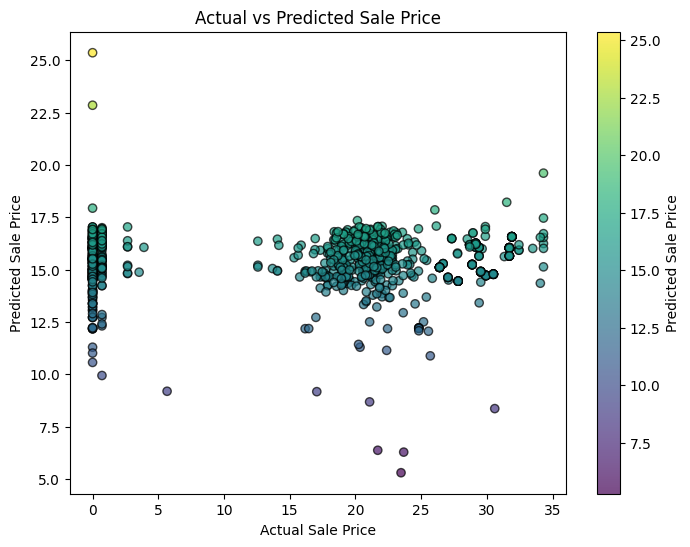

In [183]:
# Fit the model and make predictions
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print evaluation metrics
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))

# Plot with color gradient
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test, y_pred, c=y_pred, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Predicted Sale Price')

plt.show()




## Decision Tree Model:

Mean Squared Error_dt: 149.17060650526602
R-squared_dt: -0.07943053476063033


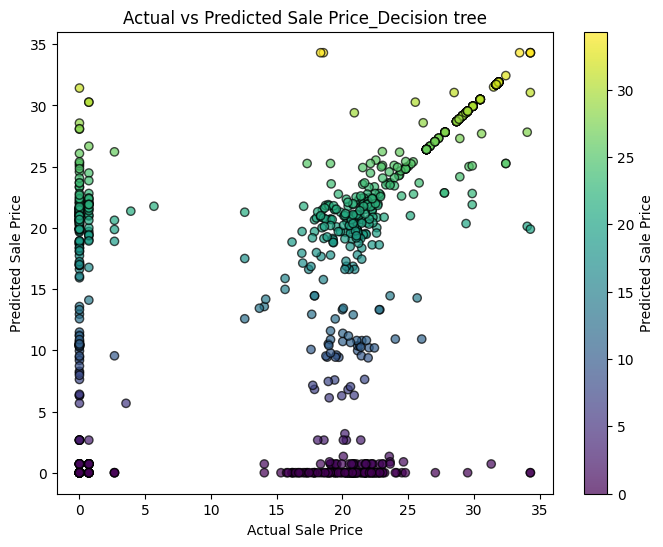

In [184]:
# Fit the model and make predictions
model_tree = DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Print evaluation metrics
print('Mean Squared Error_dt:', mean_squared_error(y_test, y_pred_tree))
print('R-squared_dt:', r2_score(y_test, y_pred_tree))

# Plot with color gradient
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test, y_pred_tree, c=y_pred_tree, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price_Decision tree')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Predicted Sale Price')

plt.show()

## Random Forest Model:

Mean Squared Error_RF: 100.21208706847221
R-squared_RF: 0.27484382300221377


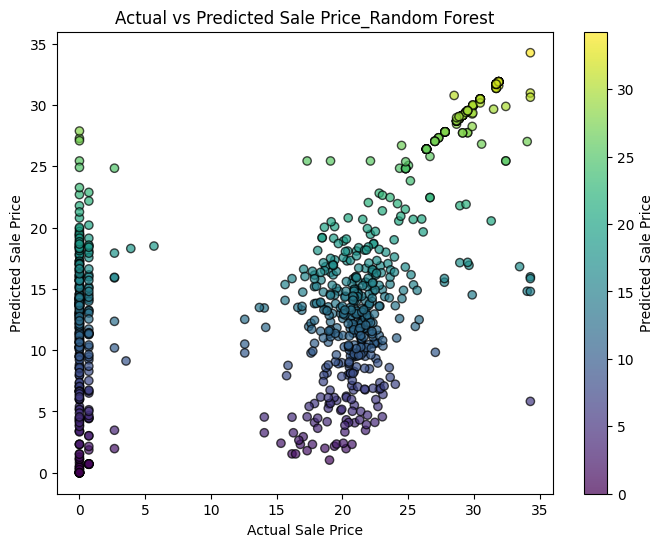

In [185]:
# Fit the model and make predictions
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Print evaluation metrics
print('Mean Squared Error_RF:', mean_squared_error(y_test, y_pred_rf))
print('R-squared_RF:', r2_score(y_test, y_pred_rf))

# Plot with color gradient
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test, y_pred_rf, c=y_pred_rf, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price_Random Forest')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Predicted Sale Price')

plt.show()

## Save the Dataset:

In [186]:
# Save cleaned dataset
data.to_csv('cleaned_real_estate_data.csv', index=False)